Here we will set the mrad to that highest interpolation factor and then keep it constant throughout the remaininder of the measurement 

In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from ase.visualize import view

In [24]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from ase.visualize import view
from ipywidgets import interactive

# Load your structure (e.g., from a .cif file)
atoms = atoms

# Function to create a rotation matrix
def rotation_matrix(alpha, beta, gamma):
    # Convert angles from degrees to radians
    alpha, beta, gamma = np.radians([alpha, beta, gamma])
    
    # Rotation matrix for x-axis
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]])
    
    # Rotation matrix for y-axis
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]])
    
    # Rotation matrix for z-axis
    Rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                   [np.sin(gamma), np.cos(gamma), 0],
                   [0, 0, 1]])

    # Combined rotation matrix (z * y * x)
    return np.dot(Rz, np.dot(Ry, Rx))

# Function to rotate the atoms interactively
def rotate_atoms(alpha, beta, gamma):
    # Create the rotation matrix
    rot_matrix = rotation_matrix(alpha, beta, gamma)
    
    # Apply the rotation to the atomic positions
    atoms.positions = np.dot(atoms.positions, rot_matrix)
    
    # Visualize the rotated structure
    view(atoms)

# Interactive widget for controlling rotation angles
interactive_plot = interactive(
    rotate_atoms, 
    alpha=(-180, 180, 1),  # Rotation around x-axis
    beta=(-180, 180, 1),   # Rotation around y-axis
    gamma=(-180, 180, 1)   # Rotation around z-axis
)

# Display the interactive rotation controls
interactive_plot


interactive(children=(IntSlider(value=0, description='alpha', max=180, min=-180), IntSlider(value=0, descripti…

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...


[########################################] | 100% Completed | 889.24 ms


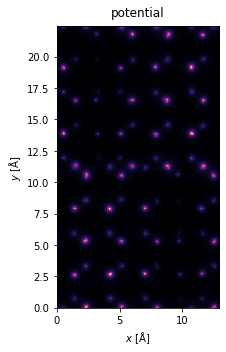

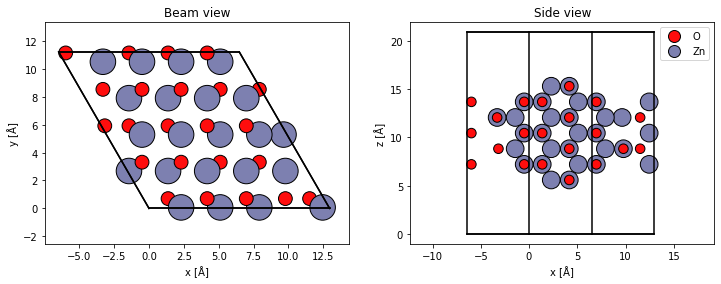

In [20]:
atoms = read(r"/dls/science/groups/e02/Joshua/Python_code/Catalyst_Models/ZnO(rp1).cif")

frozen_phonons = abtem.FrozenPhonons(atoms, num_configs=10, sigmas=0.1, seed=100)
atoms_configuration = next(iter(frozen_phonons))
potential = abtem.Potential(
    frozen_phonons,
    sampling=0.05,
    #device="gpu",
    parametrization="lobato",
    projection="infinite"
)
fig, (ax1) = plt.subplots(1,figsize=(5, 5))
potential.show(ax=ax1, cmap='magma', title="potential")
fig.tight_layout()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, title="Beam view", ax=ax1)
abtem.show_atoms(atoms, legend=True, plane="xz", title="Side view", ax=ax2);

In [15]:
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=300e3,
    semiangle_cutoff=26.7,
    interpolation=(4),
)
exit_waves_line = s_matrix.multislice(potential=potential)
sampling = abtem.transfer.nyquist_sampling(s_matrix.semiangle_cutoff, s_matrix.energy)
scan = abtem.GridScan(
    start=(0, 0),
    end=(1, 1),
    fractional=True,
    potential=potential,
    sampling=sampling,
)


/dls_sw/apps/python/miniforge/4.10.0-0/envs/epsic3.10/lib/python3.10/site-packages/abtem/prism/s_matrix.py:1473: UserWarning: The interpolation factor does not exactly divide 'gpts', normalization may not be exactly preserved.
  warnings.warn(


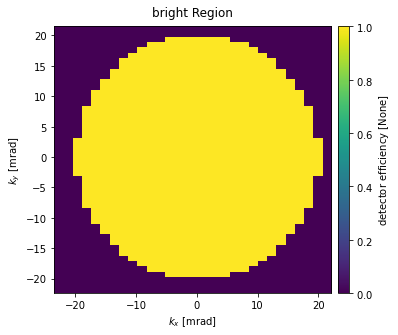

In [16]:
bright = abtem.AnnularDetector(inner=0, outer=20)
bright_region = bright.get_detector_region(exit_waves_line) 
bright_visualization = bright_region.show(
    cbar=True,     
    units="mrad",           
    figsize=(6, 6),
    title="bright Region"     
)

In [17]:
measurement = s_matrix.scan(
    scan=scan,
    detectors=bright,
).compute()

[########################################] | 100% Completed | 33.19 s


Measurement pixel size: [0.18238592 0.18384442] Å per pixel (x, y dimensions)


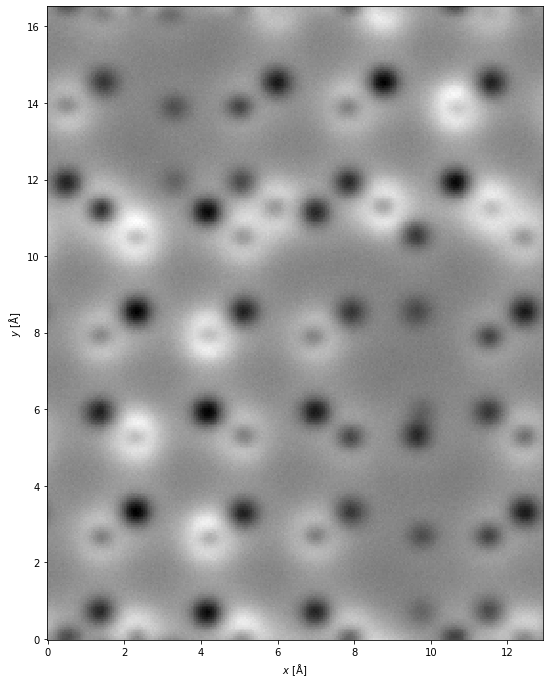

In [18]:
#interpolated_measurement = measurement.interpolate(0.05).gaussian_filter(0.2)
#interpolated_measurement.show(explode=True, cbar=True, cmap='gray', figsize=(20, 5));

interpolated_measurement = measurement.interpolate(0.05).gaussian_filter(0.2).poisson_noise(dose_per_area=1e9)
interpolated_measurement.show(
    explode=True,
    figsize=(10, 10),
    cbar=False,
    cmap='gray_r',
);

measurement_extent = measurement.extent  # Extent of the scan grid in Å
measurement_shape = measurement.shape    # Shape of the measurement grid
measurement_pixel_size = np.array(measurement_extent) / np.array(measurement_shape)
print(f"Measurement pixel size: {measurement_pixel_size} Å per pixel (x, y dimensions)")

interpolated_measurement.to_tiff("hex_pos1.tiff")

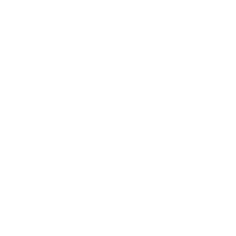

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your TIFF file
tiff_file = "/dls/science/groups/e02/Joshua/Python_code/General_TEM_simulation/sim_images/cube1_pos2.tiff"

# Open the TIFF file
img = Image.open(tiff_file)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner view
plt.show()
